#Unimodal Approach

##Dataset Acquisition

In [1]:
#Ty Mario <3

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!ls '/gdrive/MyDrive/MemesDeepLearning'

'4803 Project Proposal.gdoc'	     MMBT_training.ipynb
 CLIPBaselineipynb.ipynb	     mmbt.zip
 computed_data			    'MMF Tutorial.ipynb'
 computed_trainset.zip		     model_weights
 computed_valset		     NeuralNetworkMeme.ipynb
 computed_valset.zip		     OLIDv1
'Copy of ToxicityAnalysis.ipynb'     preprocessed_data
'Data Efficiency.gdoc'		     pretrained_models_for_image_preprocessing
 dataFB.zip			     tensorDataPreprocessed.zip
 dev_all.jsonl			     tensorDataTestOnly.zip
'DialoGPT2 (Unimodal).ipynb'	     tensorData.zip
 final_model_submission.gsheet	     test.jsonl
'Generate Clean Meme Images.ipynb'   test_unseen.jsonl
'GPT (Unimodal).ipynb'		     ToxicityAnalysis.ipynb
 IterateMemes.ipynb		     train.jsonl
 mmbt_checkpoints.zip		    'Untitled document.gdoc'
 MMBT_inference.ipynb		    'VisualBERT + CLIP.ipynb'
 mmbt_model_best.zip		     VisualGPT.ipynb


In [3]:
!cp '/gdrive/MyDrive/MemesDeepLearning/dataFB.zip' '/content/data.zip'
print("Done")

Done


In [4]:
!unzip -q data.zip
print("Unzipped")

Unzipped


##Toxic-Bert

###Dependencies

In [5]:
%%bash
pip install detoxify
print("Installed")

bash: line 2: syntax error near unexpected token `"Installed"'
bash: line 2: `print("Installed")'


In [6]:
from detoxify import Detoxify
import json
import random
import pandas as pd
from IPython.display import Image

In [7]:
data = [json.loads(jline) for jline in open('data/train.jsonl', 'r')]
images = [data[index]['img'] for index in range(len(data))]
text = [data[index]['text'] for index in range(len(data))]
print(len(text))
print(len(images))
# print(text)
print(data[0])
# display(Image('data/'+data[0]['img']))

8500
8500
{'id': 42953, 'img': 'img/42953.png', 'label': 0, 'text': 'its their character not their color that matters'}


###Training

####Encoding

In [8]:
results = Detoxify('original').predict(text[:2000])
print(pd.DataFrame(results, index=data[:2000]).round(5))

Downloading: "https://github.com/unitaryai/detoxify/releases/download/v0.1-alpha/toxic_original-c1212f89.ckpt" to /root/.cache/torch/hub/checkpoints/toxic_original-c1212f89.ckpt



                                                    toxicity  ...  identity_hate
{'id': 42953, 'img': 'img/42953.png', 'label': ...   0.00133  ...        0.00016
{'id': 23058, 'img': 'img/23058.png', 'label': ...   0.18079  ...        0.00093
{'id': 13894, 'img': 'img/13894.png', 'label': ...   0.01802  ...        0.00029
{'id': 37408, 'img': 'img/37408.png', 'label': ...   0.03131  ...        0.00045
{'id': 82403, 'img': 'img/82403.png', 'label': ...   0.03521  ...        0.00057
...                                                      ...  ...            ...
{'id': 74310, 'img': 'img/74310.png', 'label': ...   0.02154  ...        0.00025
{'id': 65087, 'img': 'img/65087.png', 'label': ...   0.76055  ...        0.43609
{'id': 69415, 'img': 'img/69415.png', 'label': ...   0.00097  ...        0.00016
{'id': 52978, 'img': 'img/52978.png', 'label': ...   0.07708  ...        0.00057
{'id': 5468, 'img': 'img/05468.png', 'label': 0...   0.40846  ...        0.00236

[2000 rows x 6 columns]


In [9]:
print(pd.DataFrame(results, index=data[:2000]).keys())

Index(['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


In [10]:
def update_x(x, results, len):
  for i in range(len):
    row = []
    row.append(results['toxicity'][i])
    row.append(results['severe_toxicity'][i])
    row.append(results['obscene'][i])
    row.append(results['threat'][i])
    row.append(results['identity_hate'][i])
    row.append(results['insult'][i])
    x.append(row)
  return x

x = []
x = update_x(x, results, 2000)
print(len(x))
print(len(x[0]))

2000
6


In [11]:
results = (Detoxify('original').predict(text[2000:4000]))
x = update_x(x, results, 2000)
print(len(x))
print(len(x[0]))

4000
6


In [12]:
results = (Detoxify('original').predict(text[4000:6000]))
x = update_x(x, results, 2000)
print(len(x))
print(len(x[0]))

6000
6


In [13]:
results = (Detoxify('original').predict(text[6000:]))
x = update_x(x, results, 2500)
print(len(x))
print(len(x[0]))

8500
6


In [14]:
validation = [json.loads(jline) for jline in open('data/dev_seen.jsonl', 'r')]
print(len(validation))
validation.extend([json.loads(jline) for jline in open('data/dev_unseen.jsonl', 'r')])
print(len(validation))
validation_text = [validation[index]['text'] for index in range(len(validation))]
print(len(validation_text))

data = [json.loads(jline) for jline in open('data/train.jsonl', 'r')]
images = [data[index]['img'] for index in range(len(data))]
text = [data[index]['text'] for index in range(len(data))]

500
1040
1040


In [15]:
validation_encoded = Detoxify('original').predict(validation_text)
y = []
y = update_x(y, validation_encoded, len(validation_text))
print(len(y))
print(len(y[0]))

1040
6


####Neural Networks

In [28]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [29]:
batch_size = 64

train_ground = torch.from_numpy(np.array([data[index]['label'] for index in range(len(data))]))
train_ground_batch = torch.split(train_ground, batch_size)
train_data = torch.from_numpy(np.array(x))
train_data_batch = torch.split(train_data, batch_size)

validation_data = torch.from_numpy(np.array(y))
validation_ground = torch.from_numpy(np.array([validation[index]['label'] for index in range(len(validation))]))

In [82]:
class ToxicityModel(nn.Module):
  def __init__(self):
    super(ToxicityModel, self).__init__()
    hidden_size = 8
    self.linear1 = nn.Linear(6, hidden_size)
    self.dropout = nn.Dropout(p=0.4)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, 2)
  
  def forward(self, x):
    x = self.linear1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.linear2(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.linear3(x)
    x = F.relu(x)
    return x

class SimpleToxicityModel(nn.Module):
  def __init__(self):
    super(SimpleToxicityModel, self).__init__()
    hidden_size = 4
    self.linear1 = nn.Linear(6, hidden_size)
    self.dropout = nn.Dropout(p=0.1)
    self.linear2 = nn.Linear(hidden_size, 2)
  
  def forward(self, x):
    x = self.linear1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.linear2(x)
    #x = F.relu(x)
    return x

torch.Size([8500, 6])
This is BETTER than the old model which has 0%
[1,   133] loss: 0.662 0.0% 57.01923%
[2,   133] loss: 0.647 0.0% 57.01923%
[3,   133] loss: 0.646 0.0% 57.01923%
[4,   133] loss: 0.642 0.0% 57.01923%
[5,   133] loss: 0.638 11.5% 57.01923%
[6,   133] loss: 0.636 19.2% 57.01923%
This is BETTER than the old model which has 57.01923076923077%
[7,   133] loss: 0.630 23.1% 57.78846%
[8,   133] loss: 0.628 28.8% 57.50000%
This is BETTER than the old model which has 57.78846153846154%
[9,   133] loss: 0.625 25.0% 58.17308%
[10,   133] loss: 0.622 30.8% 58.17308%
[11,   133] loss: 0.615 38.5% 57.78846%
[12,   133] loss: 0.617 23.1% 58.07692%
This is BETTER than the old model which has 58.17307692307692%
[13,   133] loss: 0.616 34.6% 58.36538%
This is BETTER than the old model which has 58.36538461538461%
[14,   133] loss: 0.614 28.8% 58.65385%
[15,   133] loss: 0.612 30.8% 58.26923%
[16,   133] loss: 0.610 40.4% 58.46154%
[17,   133] loss: 0.609 44.2% 58.26923%
[18,   133] 

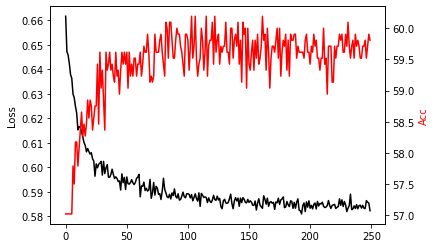

In [83]:
import matplotlib.pyplot as plt
import copy

x = torch.from_numpy(np.array(x))
print(x.shape)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = ToxicityModel()
#model = SimpleToxicityModel()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

runLoss = []
runAcc = []
maxAccTemp = 0
bestAccuracy=0
for epoch in range(250):
    running_loss = 0.0

    for i in range(len(train_data_batch)):
        
        inputs = train_data_batch[i].to(device)
        labels = train_ground_batch[i].type(torch.LongTensor).to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.float())
        #print(outputs.dtype)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        howOften = len(train_data_batch)
        if i % howOften == howOften-1:
            _, predicted = torch.max(outputs.data, 1)
            numCorrect = (predicted == labels).sum().item()
            acc = (100.0 * numCorrect / labels.shape[0])
            #print(outputs)
            #print(labels)
            model.eval()
            with torch.no_grad():
                validation_data = validation_data.to(device)
                validation_ground = validation_ground.to(device)
                outputs = model(validation_data.float())
                #print(test_data.shape)
                _, predicted = torch.max(outputs.data, 1)
                numCorrect = (predicted == validation_ground).sum().item()
                acc2 = (100.0 * numCorrect / validation_data.shape[0])
                runAcc.append(acc2)
                if acc2>maxAccTemp:
                  maxAccTemp = acc2
                if acc2>bestAccuracy:
                  print(f"This is BETTER than the old model which has {bestAccuracy}%")
                  bestAccuracy = acc2
                  bestModel = copy.deepcopy(model)
                #print('Accuracy of the network on the test data: %f %%' % acc2)
                print('[%d, %5d] loss: %.3f %.1f%% %.5f%%' %
                  (epoch + 1, i + 1, running_loss / howOften, acc, acc2))
                #print(f"Current best: {bestAccuracy} %")
            model.train()
            runLoss.append(running_loss / howOften)
            running_loss = 0.0
    #scheduler.step()
print(f'Finished Training with max acc {maxAccTemp}%')
print(model)
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.plot(runLoss, color='black')
ax_right.plot(runAcc, color='red')

ax_left.set_ylabel("Loss", color='black')
ax_right.set_ylabel("Acc", color='red')
plt.xlabel("Epoch")
plt.show()

# runLoss = []
# for epoch in range(250):
#     running_loss = 0.0

#     for i in range(len(train_data_batch)):
        
#         inputs = train_data_batch[i].to(device)
#         labels = train_ground_batch[i].type(torch.LongTensor).to(device)
        
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         #print(inputs.shape)
#         outputs = model(inputs.float())
#         #print(outputs.dtype)
#         #print(outputs[0])
        
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         howOften = len(train_data_batch)
#         if i % howOften == howOften-1:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / howOften))
#             #print(outputs)
#             #print(labels)
#             runLoss.append(running_loss / howOften)
#             running_loss = 0.0
#     #scheduler.step()
# print('Finished Training')
# plt.plot(runLoss)
# plt.ylabel("Loss")
# plt.xlabel("Epoch")
# plt.show()

####Validation

In [84]:
bestAcc = 0

In [85]:
resultTest = validation
resultTensor = torch.zeros(len(resultTest))
for i in range(len(resultTest)):
  resultTensor[i] = resultTest[i]['label']

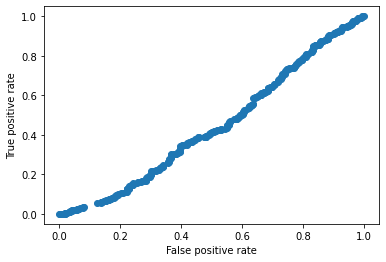

Accuracy: 59.80769230769231 AUROC: 0.5559491607908824
Accuracy of the network on the validation data: 59.807692 %
Best accuracy:  60.1923 %


ToxicityModel(
  (linear1): Linear(in_features=6, out_features=8, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (linear2): Linear(in_features=8, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=2, bias=True)
)

In [87]:
from sklearn import metrics
model.eval()
with torch.no_grad():
    validation_data = validation_data.to(device)
    validation_ground = validation_ground.to(device)
    outputs = model(validation_data.float())
    outputs = F.softmax(outputs, dim=1)
    _, predicted = torch.max(outputs.data, 1)
    numCorrect = (predicted == validation_ground).sum().item()
    probs = outputs[:,1].cpu().numpy()
    acc = (100.0 * numCorrect / validation_data.shape[0])
    fpr, tpr, thresholds = metrics.roc_curve(resultTensor, probs, pos_label=1)
    auroc = metrics.auc(tpr, fpr)
    plt.scatter(fpr,tpr)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()
    print(f"Accuracy: {acc} AUROC: {auroc}")
    if acc > bestAcc:
      bestAcc = acc
    print('Accuracy of the network on the validation data: %f %%' % acc)
    print('Best accuracy: ', bestAcc, '%')
model.train()

##Testing

In [43]:
!cp '/gdrive/MyDrive/MemesDeepLearning/test.jsonl' '/content/data/test.jsonl'

In [44]:
test = [json.loads(jline) for jline in open('data/test.jsonl', 'r')]
print(len(test))
#test.extend([json.loads(jline) for jline in open('data/test_unseen.jsonl', 'r')])
#print(len(test))
test_text = [test[index]['text'] for index in range(len(test))]
print(len(test))

1000
1000


In [64]:
test_encoded = Detoxify('original').predict(test_text)
test_x = []
test_x = update_x(test_x, test_encoded, len(test_text))
print(len(test_x))
print(len(test_x[0]))

1000
6


In [88]:
test_data = torch.from_numpy(np.array(test_x))
test_ground = torch.from_numpy(np.array([test[index]['label'] for index in range(len(test))]))
resultTest = test
resultTensor = torch.zeros(len(resultTest))
for i in range(len(resultTest)):
  resultTensor[i] = resultTest[i]['label']

In [90]:
# model = bestModel
model.eval()
with torch.no_grad():
    test_data = test_data.to(device)
    test_ground = test_ground.to(device)
    outputs = model(test_data.float())
    outputs = F.softmax(outputs, dim=1)
    _, predicted = torch.max(outputs.data, 1)
    numCorrect = (predicted == test_ground).sum().item()
    acc = (100.0 * numCorrect / test_data.shape[0])
    print('Accuracy of the network on the test data: %f %%' % acc)
    probs = outputs[:,1].cpu().numpy()
    fpr, tpr, thresholds = metrics.roc_curve(test_ground.cpu(), probs, pos_label=1)
    auroc = metrics.auc(tpr, fpr)
    print("AUROC: ", auroc)
model.train()

Accuracy of the network on the test data: 55.600000 %
AUROC:  0.6016686674669868


ToxicityModel(
  (linear1): Linear(in_features=6, out_features=8, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (linear2): Linear(in_features=8, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=2, bias=True)
)

In [67]:
while(True):
  pass

KeyboardInterrupt: ignored